In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder


from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, classification_report

In [2]:
data=pd.read_csv('../../data/Wholesale customers data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
data.shape

(440, 8)

In [4]:
data.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [5]:
data.duplicated().sum()

np.int64(0)

In [6]:
data.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

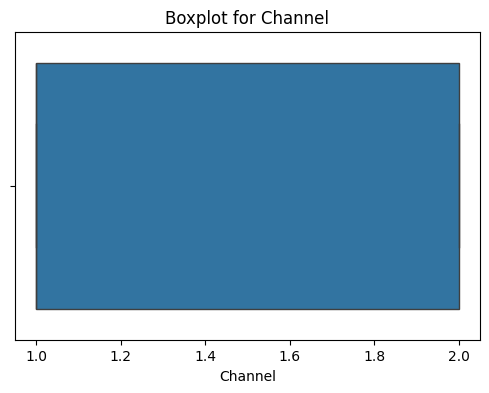

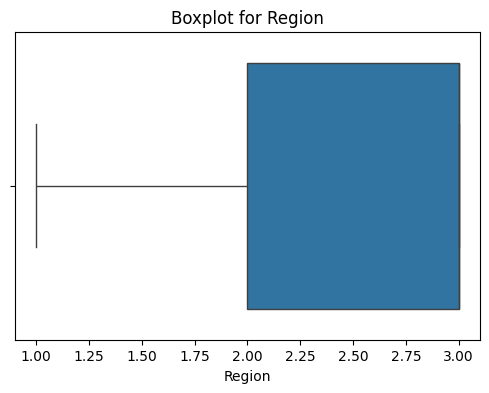

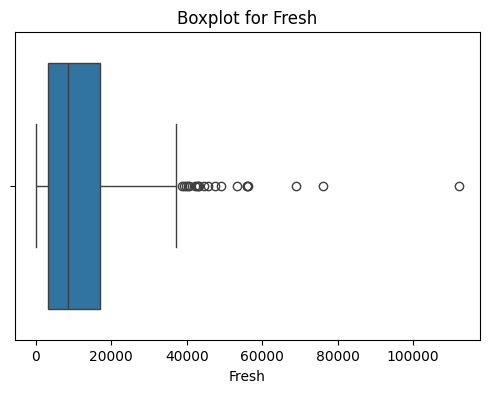

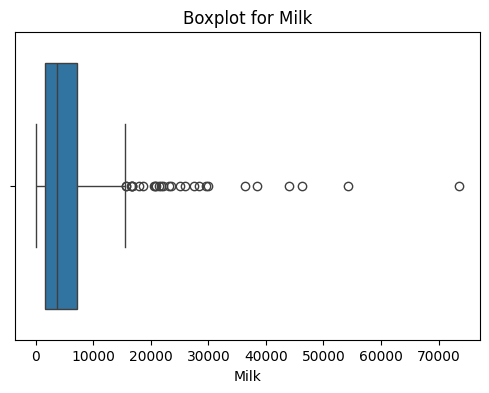

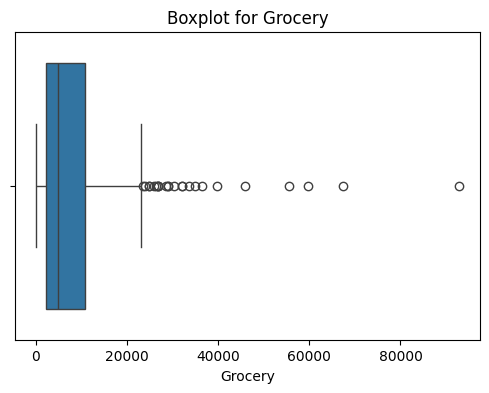

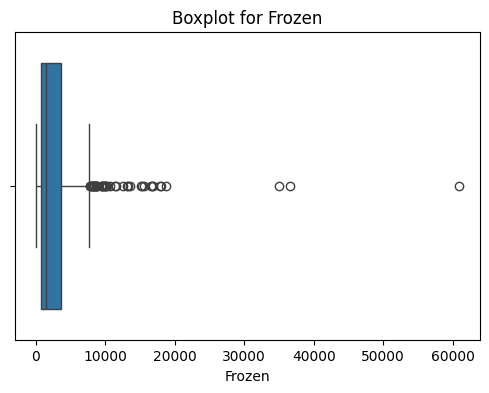

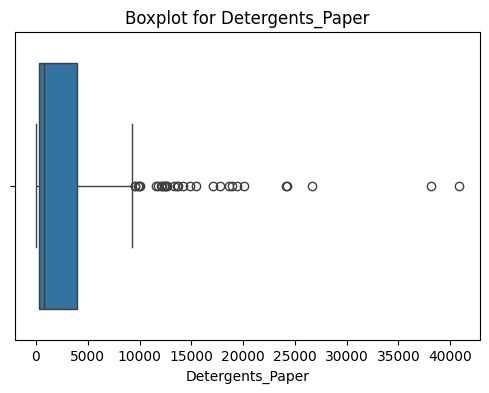

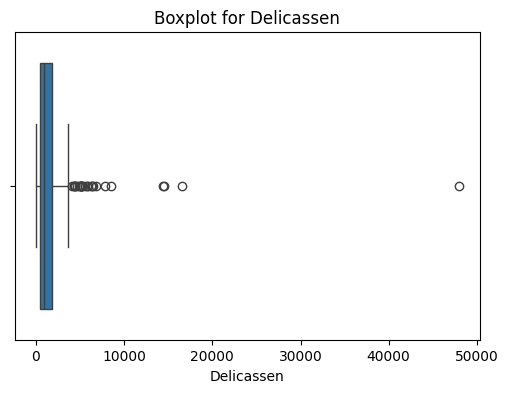

In [7]:
data.columns = data.columns.str.strip()
numeric_columns = data.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    plt.figure(figsize=(6, 4))  
    sns.boxplot(x=data[col])    
    plt.title(f"Boxplot for {col}")  
    plt.show()

In [8]:
def handle_outliers_clip(data):
    for col in data.select_dtypes(include=[np.number]).columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)    
    return data

data_no_outliers_clip = handle_outliers_clip(data)
print(data_no_outliers_clip.head())

   Channel  Region    Fresh    Milk  Grocery  Frozen  Detergents_Paper  \
0        2       3  12669.0  9656.0   7561.0   214.0            2674.0   
1        2       3   7057.0  9810.0   9568.0  1762.0            3293.0   
2        2       3   6353.0  8808.0   7684.0  2405.0            3516.0   
3        1       3  13265.0  1196.0   4221.0  6404.0             507.0   
4        2       3  22615.0  5410.0   7198.0  3915.0            1777.0   

   Delicassen  
0     1338.00  
1     1776.00  
2     3938.25  
3     1788.00  
4     3938.25  


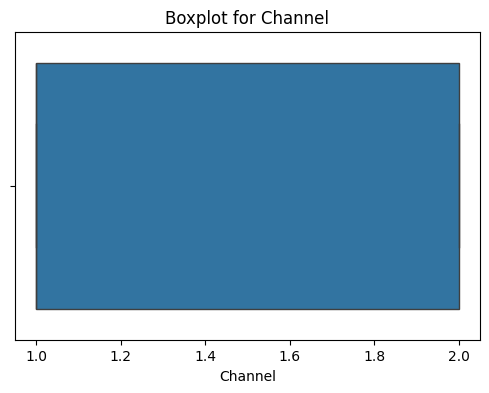

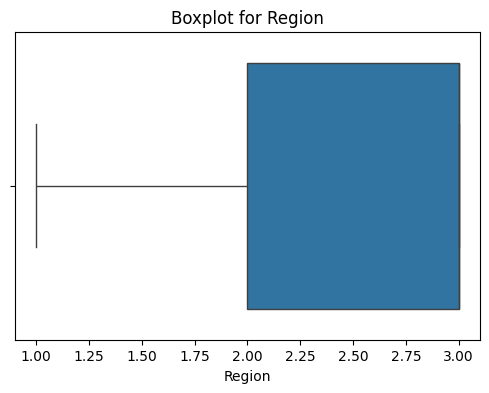

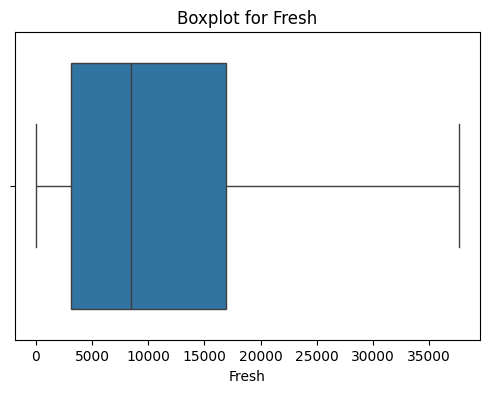

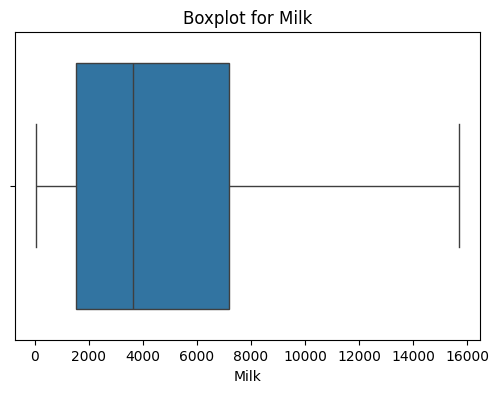

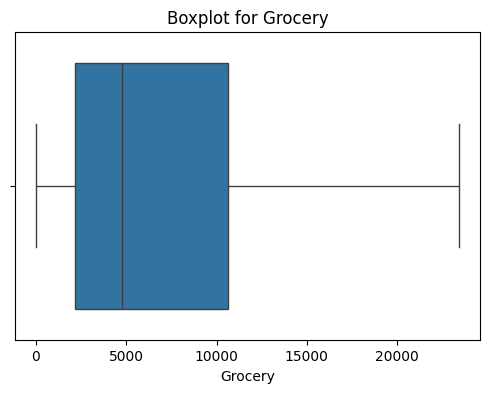

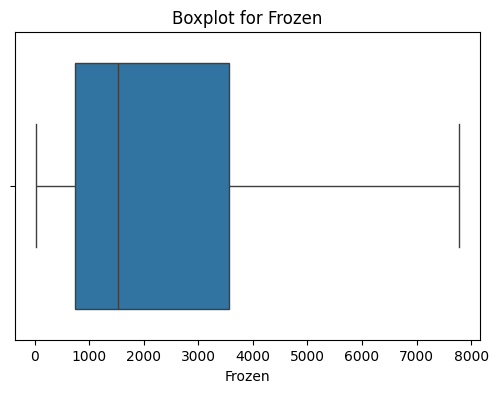

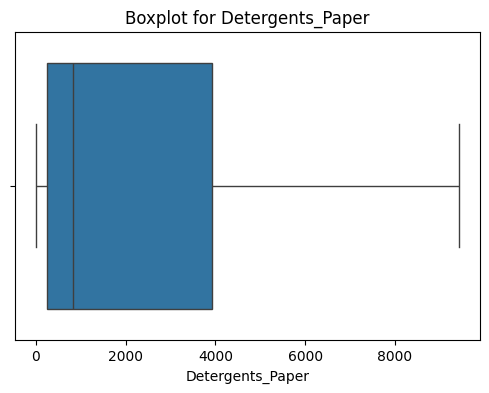

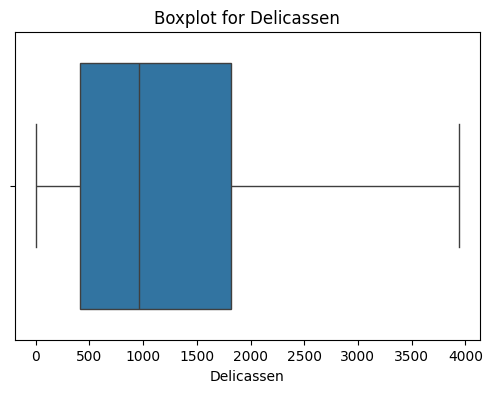

In [9]:
# checking if outliers still exist
data.columns = data.columns.str.strip()
numeric_columns = data.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    plt.figure(figsize=(6, 4))  
    sns.boxplot(x=data[col])    
    plt.title(f"Boxplot for {col}")  
    plt.show()

In [10]:
X = data.drop(columns=['Channel', 'Region'])
X.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669.0,9656.0,7561.0,214.0,2674.0,1338.00
1,7057.0,9810.0,9568.0,1762.0,3293.0,1776.00
2,6353.0,8808.0,7684.0,2405.0,3516.0,3938.25
3,13265.0,1196.0,4221.0,6404.0,507.0,1788.00
4,22615.0,5410.0,7198.0,3915.0,1777.0,3938.25


In [11]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

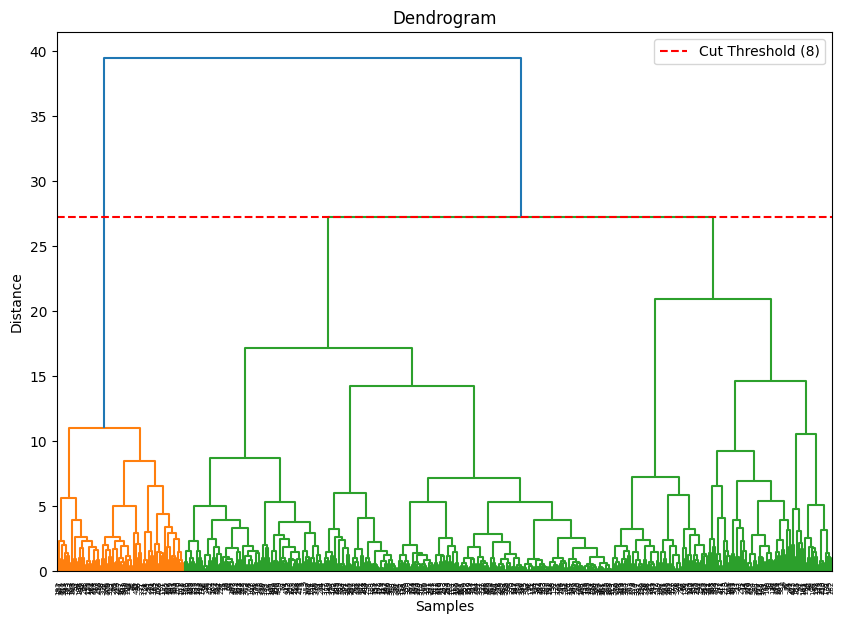

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_matrix = linkage(scaled_data, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Dendrogram')
dend = dendrogram(linkage_matrix)

# Add a horizontal cut threshold
distance_gaps = np.diff(linkage_matrix[:, 2])
# Find the largest gap (indicating a significant jump in distance)
largest_gap_index = np.argmax(distance_gaps)
optimal_y = linkage_matrix[largest_gap_index, 2]

plt.axhline(optimal_y, color='r', linestyle='--', label='Cut Threshold (8)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.legend()
plt.show()

In [41]:
from sklearn.cluster import AgglomerativeClustering
agg_clust = AgglomerativeClustering(n_clusters=3, linkage='ward')  # n_clusters=3 for 3 clusters
clusters = agg_clust.fit_predict(scaled_data)
data['Cluster'] = clusters

In [42]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,2,3,12669.0,9656.0,7561.0,214.0,2674.0,1338.00,2
1,2,3,7057.0,9810.0,9568.0,1762.0,3293.0,1776.00,2
2,2,3,6353.0,8808.0,7684.0,2405.0,3516.0,3938.25,0
3,1,3,13265.0,1196.0,4221.0,6404.0,507.0,1788.00,0
4,2,3,22615.0,5410.0,7198.0,3915.0,1777.0,3938.25,0


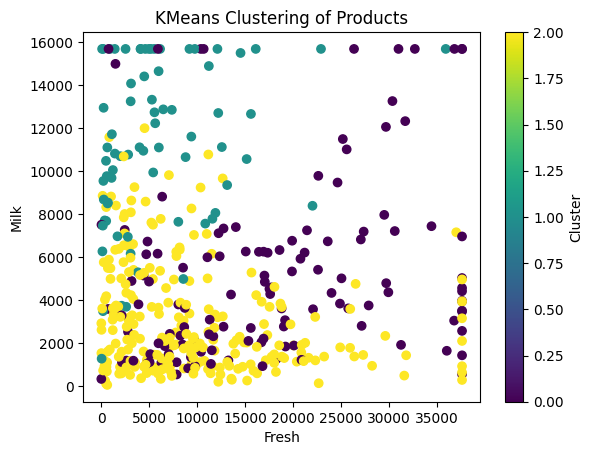

In [43]:
# Visualize the clusters
plt.scatter(data['Fresh'], data['Milk'], c=data['Cluster'], cmap='viridis')
plt.xlabel('Fresh')
plt.ylabel('Milk')
plt.title('KMeans Clustering of Products')
plt.colorbar(label='Cluster')
plt.show()

In [44]:
Y=data['Cluster']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_data, Y, test_size=0.2, random_state=42)

In [45]:
classifiers = {
    'Random Forest Classifier': RandomForestClassifier(n_estimators=47, random_state=34),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(kernel='linear'),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42, learning_rate=0.3),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=600, learning_rate=0.05, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  
    y_pred = clf.predict(X_test)  
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy * 100:.2f}%')

Random Forest Classifier Accuracy: 96.59%
Logistic Regression Accuracy: 94.32%
SVM Accuracy: 93.18%
KNN Accuracy: 98.86%
Naive Bayes Accuracy: 95.45%
Decision Tree Accuracy: 95.45%
AdaBoost Accuracy: 87.50%
Gradient Boosting Accuracy: 96.59%
XGBoost Accuracy: 96.59%


In [46]:
# END